In [1]:
import sys, os
import json
import pandas as pd
import numpy as np
import time, math
from operator import sub
from scipy.interpolate import interp1d
import matplotlib
import matplotlib.transforms as transforms
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

v = 27


/tmp/ipykernel_8973/2259420474.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


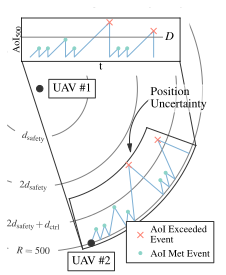

In [32]:
def add_inset(ax, rect, *args, **kwargs):
    box = ax.get_position()
    inax_position = ax.transAxes.transform(rect[0:2])
    infig_position = ax.figure.transFigure.inverted().transform(inax_position)
    new_rect = list(infig_position) + [box.width * rect[2], box.height * rect[3]]
    return fig.add_axes(new_rect, *args, **kwargs)

def fmt(x):
    labels = {
        150: r'$d_\mathrm{{safety}}$',
        300: r'$2d_\mathrm{{safety}}$',
        420: r'$2d_\mathrm{{safety}}+d_\mathrm{{ctrl}}$',
        500: r'$R = 500$',

    }
    return labels[int(x)]

uav_width = 20
fig, ax = plt.subplots()
color = '#7eb0d5'
rcvd_color = '#8bd3c7'
aoi_exceeded_color = '#fd7f6f'
v_max = 35

t = np.array([1, 2, 2, 3, 3, 5, 5, 6, 6, 10, 10, 11, 11, 12, 12, 15, 15])
aoi = np.array([0, 1, 0, 1, 0, 2, 0, 1 , 0, 4, 0, 1, 0, 1, 0, 3, 0])

t_max = 16

# ax.plot(t, aoi)

R = 500

x = np.arange(-600, 600, 1)
y = np.arange(-600, 600, 1)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(X * X + Y * Y)

label_positions = [(-20, -150), (-20, -300), (-20, -420), (-20, -500)]
#manual_locations = [(-1, -1.4), (-0.62, -0.7), (-2, 0.5), (1.7, 1.2), (2.0, 1.4), (2.4, 1.7)]

CS = ax.contour(X, Y, Z, [150, 300, 420, 500], colors=['#808080']*4, linewidths=1)
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10, manual=label_positions, inline_spacing=20, colors='#333')
ax.set_aspect('equal')


uav_1 = matplotlib.patches.Ellipse((0,0), width=uav_width, height=uav_width, fill=True, lw=1, ec='#333', fc='#333', clip_on=True)
ax.add_patch(uav_1)
ax.text(40, 0, 'UAV \#1', va='center', ha='left', bbox=dict(pad=4, lw=1, fc='#fff', color='#333'))

ax.set_ylim([-550, 250])
ax.set_xlim([-100, 550])

a = matplotlib.patches.Rectangle((-120, 40), width=580, height=220, lw=0, fc='#fff', zorder=2)
ax.add_patch(a)
ax2 = add_inset(ax, [-0.05, 0.85, 0.9, 0.2])

ax2.plot(t, aoi, lw=1, color=color)
ax2.text(t_max + 0.8, 80/v_max, '$D$', ha='center', va='center')
ax2.plot([0, t_max],[80/v_max, 80/v_max], '-', color='#808080', lw=1)

ax2.set_ylim([-0.5, 4.5])
ax2.set_xlim([0, t_max + 2])

for t_i, aoi_i in zip(t, aoi):
    if aoi_i > 0:
        c_i = aoi_exceeded_color if aoi_i > 80/v_max else rcvd_color
        icon_i = 'x' if aoi_i > 80/v_max else '.'
        ax2.plot(t_i, aoi_i, icon_i, color=c_i, lw=1)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel(r'$\mathrm{AoI}_{500}$', labelpad=0, fontsize=10)
ax2.set_xlabel('t', labelpad=0)


ax.text(340, -30, 'Position \nUncertainty', ha='left', va='center', bbox=dict(pad=2, lw=1, fc='#fff', color='#fff', alpha=0.6))
arrow = patches.FancyArrowPatch((340, -30), (280, -200), connectionstyle=f"arc3,rad=0.3", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#333')
ax.add_patch(arrow)

R_1 = 1.02 * R
R_2 = (R - 150)

start_angle = -75 / 180 * math.pi
end_angle = -20 / 180 * math.pi
p_0_x = R_1 * math.cos(start_angle)
p_0_y = R_1 * math.sin(start_angle)
p_3_x = R_2 * math.cos(start_angle)
p_3_y = R_2 *  math.sin(start_angle)
p_1_x = R_1 * math.cos(end_angle)
p_1_y = R_1 * math.sin(end_angle)
p_2_x = R_2 * math.cos(end_angle)
p_2_y = R_2 *  math.sin(end_angle)
ax.plot([p_0_x, p_3_x],[p_0_y, p_3_y], color='#333', lw=1)
ax.plot([p_1_x, p_2_x],[p_1_y, p_2_y], color='#333', lw=1)

step = 0.1 / 180 * math.pi
phi = np.arange(start_angle, end_angle + step, step)
arc_1_x = R_1 * np.cos(phi)
arc_1_y = R_1 * np.sin(phi)
arc_2_x = R_2 * np.cos(phi)
arc_2_y = R_2 * np.sin(phi)
ax.plot(arc_1_x, arc_1_y, color='#333', lw=1)
ax.plot(arc_2_x, arc_2_y, color='#333', lw=1)

a_1_x = 430
a_1_y = 85

a_2_x = -55
a_2_y = 85

ax.plot([a_1_x, p_1_x],[a_1_y, p_1_y], color='#333', lw=1)
ax.plot([a_2_x, p_0_x],[a_2_y, p_0_y], color='#333', lw=1)

t_arc = (-np.array(aoi)*v_max + R) * np.cos(start_angle + (np.array(t) / t_max) * (end_angle - start_angle))
aoi_arc = (-np.array(aoi)* v_max + R) * np.sin(start_angle + (np.array(t) / t_max) * (end_angle - start_angle))


ax.plot(t_arc, aoi_arc, lw=1, color=color)
for t_i, aoi_i in zip(t_arc, aoi_arc):
    dist = math.sqrt(t_i**2 + aoi_i**2)
    if dist < R * 0.99:
        c_i = aoi_exceeded_color if dist <= 420 else rcvd_color
        icon_i = 'x' if dist <= 420 else '.'
        ax.plot(t_i, aoi_i, icon_i, color=c_i, lw=1)

uav_2 = matplotlib.patches.Ellipse((t_arc[0],aoi_arc[0]), width=uav_width, height=uav_width, fill=True, lw=1, ec='#333', fc='#333', clip_on=True, zorder=2)
ax.add_patch(uav_2)
ax.text(t_arc[0], aoi_arc[0] -40, 'UAV \#2', va='top', ha='center', bbox=dict(pad=4, lw=1, fc='#fff', color='#333'))

ax.set_xticks([])
ax.set_yticks([])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.plot(-1000, 0, 'x', color=aoi_exceeded_color, lw=1, label='AoI Exceeded \nEvent')
ax.plot(-1000, 0, '.', color=rcvd_color, lw=1,  label='AoI Met Event')
leg = ax.legend(loc='lower right', prop={'size': 10}, fancybox=False, framealpha=1.0, handletextpad=0)
leg.get_frame().set_edgecolor('#333')
fig.tight_layout()

fig.savefig(f"../figures/ep_schematic_2_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"../figures/ep_schematic_2_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.1)

plt.show()

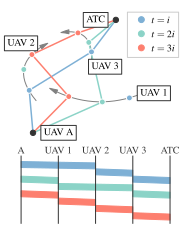

In [3]:
uav_width = 20
fig, ax = plt.subplots()
color_1 = '#7eb0d5'
color_2 = '#8bd3c7'
color_3 = '#fd7f6f'


ax.set_aspect('equal')

pos_A = (194, 336)
pos_B = (500, 753)

path_1 = [(550, 465), (450, 450), (326, 470)]
path_2 = [(180, 493), (160, 570), (190, 625)]
path_3 = [(410, 635), (400, 670), (360, 705)]

# for i, path in enumerate([path_1, path_2, path_3]):
#     p_0_x = path[1][0] + (path[0][0] - path[1][0]) * stretch_back[i]
#     p_0_y = path[1][1] + (path[0][1] - path[1][1]) * stretch_back[i]
#     p_1_x = path[1][0] + (path[2][0] - path[1][0]) * stretch_front[i]
#     p_1_y = path[1][1] + (path[2][1] - path[1][1]) * stretch_front[i]

#     print(i, (p_0_x, p_0_y), (p_1_x, p_1_y))
    # arrow = patches.FancyArrowPatch((p_0_x, p_0_y), (p_1_x, p_1_y), connectionstyle=f"arc3,rad={arcs[i]}", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#808080')
    # ax.add_patch(arrow)

arrow = patches.FancyArrowPatch((600.0, 482.5), (249, 504.0), connectionstyle=f"arc3,rad=-0.24", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#808080')
ax.add_patch(arrow)
ax.text(590, 482, 'UAV 1', va='center', ha='left', fontsize=10, bbox=dict(pad=3, lw=1, fc='#fff', color='#333'))

arrow = patches.FancyArrowPatch((210.0, 449.5), (255.0, 670.0), connectionstyle=f"arc3,rad=-0.65", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#808080')
ax.add_patch(arrow)
ax.text(200, 650, 'UAV 2', va='bottom', ha='right', fontsize=10, bbox=dict(pad=3, lw=1, fc='#fff', color='#333'))

arrow = patches.FancyArrowPatch((410, 600), (290.0, 705.0), connectionstyle=f"arc3,rad=0.65", arrowstyle="Simple, tail_width=0, head_width=4, head_length=8", color='#808080')
ax.add_patch(arrow)
ax.text(410, 580, 'UAV 3', va='center', ha='left', fontsize=10, bbox=dict(pad=3, lw=1, fc='#fff', color='#333'))


tx_0 = [pos_A, path_2[0], path_3[0], pos_B]
tx_1 = [pos_A, path_1[1], path_3[1], pos_B]
tx_2 = [pos_A, path_1[2], path_2[2], path_3[2], pos_B]

ax.plot([p[0] for p in tx_0], [p[1] for p in tx_0], '-', color=color_1)
ax.plot([p[0] for p in tx_1], [p[1] for p in tx_1], '-', color=color_2)
ax.plot([p[0] for p in tx_2], [p[1] for p in tx_2], '-', color=color_3)

colors = [color_1, color_2, color_3]

for path in [path_1, path_2, path_3]:
    for i in range(len(path)):
        uav = matplotlib.patches.Ellipse(path[i], width=uav_width + 2, height=uav_width + 2, fill=True, lw=1, ec='#fff', fc=colors[i], clip_on=True, zorder=3)
        ax.add_patch(uav)

uav_1 = matplotlib.patches.Ellipse(pos_A, width=uav_width, height=uav_width, fill=True, lw=1, ec='#333', fc='#333', clip_on=True, zorder=2)
ax.add_patch(uav_1)
ax.text(234, 336, 'UAV A', va='center', ha='left', fontsize=10, bbox=dict(pad=3, lw=1, fc='#fff', color='#333'))

uav_2 = matplotlib.patches.Ellipse(pos_B, width=uav_width, height=uav_width, fill=True, lw=1, ec='#333', fc='#333', clip_on=True, zorder=2)
ax.add_patch(uav_2)
ax.text(460, 753, 'ATC', va='center', ha='right', fontsize=10, bbox=dict(pad=3, lw=1, fc='#fff', color='#333'))
#ax.text(40, 60, 'UAV \#1', va='bottom', ha='center', bbox=dict(pad=4, lw=1, fc='#fff', color='#333'))

# ax.plot([0, 800], [290, 290], color='#dadada', lw =1)


x_min = 100
x_max = 750
height = 250
margin = 50
width = x_max - x_min - 2 * margin
tx_height = 22
prop_height = 5
ax.set_ylim([0, 800])
ax.set_xlim([x_min, x_max])

## plot lines
for i in range(5):
    x = x_min + margin + width / 4 * i
    ax.plot([x, x], [0, height], lw=1, color='#333')
    txt = 'A' if i == 0 else ('ATC' if i == 4 else f'UAV {i}')
    ax.text(x, height+10, txt, fontsize = 10, ha='center', color='#333')


height -= 20

for (t, start_node, end_node) in [(0, 0, 2), (prop_height + tx_height, 2, 3), (2* (prop_height + tx_height), 3, 4)]:
    x_start = x_min + margin + width / 4 * start_node
    x_end = x = x_min + margin + width / 4 *end_node
    y_start = height - t
    tx = plt.Polygon([[x_start, y_start], [x_end, y_start - prop_height], [x_end, y_start - prop_height - tx_height], [x_start, y_start - tx_height], [x_start, y_start]], fill=True, lw=1, fc=color_1, ec=color_1)
    ax.add_patch(tx)

for (t, start_node, end_node) in [(2 * (prop_height + tx_height), 0, 1), (3 * (prop_height + tx_height), 1, 3) , (4 * (prop_height + tx_height), 3, 4)]:
    x_start = x_min + margin + width / 4 * start_node
    x_end = x = x_min + margin + width / 4 *end_node
    y_start = height - t
    tx = plt.Polygon([[x_start, y_start], [x_end, y_start - prop_height], [x_end, y_start - prop_height - tx_height], [x_start, y_start - tx_height], [x_start, y_start]], fill=True, lw=1, fc=color_2, ec=color_2)
    ax.add_patch(tx)

for (t, start_node, end_node) in [(4 * (prop_height + tx_height), 0, 1), (5 * (prop_height + tx_height), 1, 2), (6 * (prop_height + tx_height), 2, 3), (7 * (prop_height + tx_height), 3, 4)]:
    x_start = x_min + margin + width / 4 * start_node
    x_end = x = x_min + margin + width / 4 *end_node
    y_start = height - t
    tx = plt.Polygon([[x_start, y_start], [x_end, y_start - prop_height], [x_end, y_start - prop_height - tx_height], [x_start, y_start - tx_height], [x_start, y_start]], fill=True, lw=1, fc=color_3, ec=color_3)
    ax.add_patch(tx)



ax.set_xticks([])
ax.set_yticks([])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

ax.plot(-1,-1, 'o', color=color_1, label='$t = i$')
ax.plot(-1,-1, 'o', color=color_2, label='$t = 2i$')
ax.plot(-1,-1, 'o', color=color_3, label='$t = 3i$')

ax.legend(loc='upper right', prop={'size': 10}, fancybox=False, framealpha=1.0, handletextpad=0)

fig.savefig(f"../figures/dr_schematic_2_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.1)
fig.savefig(f"../figures/dr_schematic_2_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.1)

plt.show()